In [12]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as st

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer 

from sklearn.model_selection import RandomizedSearchCV, train_test_split

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb

from sklearn.metrics import accuracy_score, mean_squared_error, confusion_matrix, roc_auc_score, roc_curve

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [6]:
train = pd.read_csv('./train.csv')

# preprocessing

In [8]:
num_col = [f for f in train.columns if train.dtypes[f] != 'object']
cat_col = [f for f in train.columns if train.dtypes[f] == 'object']

def impute(df, num_col, cat_col):
    df_out = df.copy()
    for c in num_col:
        if df_out[c].isna().any():
            m = df_out[c].dropna().median()
            df_out[c] = df_out[c].fillna(m)

    for c in cat_col:
        if df_out[c].isna().any():
            df_out[c] = df_out[c].fillna('MISSING')
            
    return df_out

cat_trans = Pipeline(
    steps=[
        ('imput', SimpleImputer(strategy='constant', missing_values='Missing')),
        ('onehot', OneHotEncoder())
    ]
)
num_trans = Pipeline(
    steps=[
        ('imput', SimpleImputer(strategy='median')),
        ('scale', StandardScaler())
    ]
)
coltrans = ColumnTransformer(
    transformers=[
        ('cat', cat_trans, cat_col),
        ('num', num_trans, num_col)
    ],
    remainder='passthrough',
    sparse_threshold=0
)


In [10]:
def get_column_names_from_ColumnTransformer(column_transformer):    
    col_name = []
    for transformer_in_columns in column_transformer.transformers_[:-1]:#the last transformer is ColumnTransformer's 'remainder'
        raw_col_name = transformer_in_columns[2]
        if isinstance(transformer_in_columns[1],Pipeline): 
            transformer = transformer_in_columns[1].steps[-1][1]
        else:
            transformer = transformer_in_columns[1]
        try:
            names = transformer.get_feature_names()
        except AttributeError: # if no 'get_feature_names' function, use raw column name
            names = raw_col_name
        if isinstance(names,np.ndarray): # eg.
            col_name += names.tolist()
        elif isinstance(names,list):
            col_name += names    
        elif isinstance(names,str):
            col_name.append(names)
    return col_name

In [ ]:
# A good way to encode categorical features into ordinal numerical feature based on group mean
def encode(frame, feature):
    ordering = pd.DataFrame()
    ordering['val'] = frame[feature].unique()
    ordering.index = ordering.val
    ordering['spmean'] = frame[[feature, 'SalePrice']].groupby(feature).mean()['SalePrice']
    ordering = ordering.sort_values('spmean')
    ordering['ordering'] = range(1, ordering.shape[0]+1)
    ordering = ordering['ordering'].to_dict()
    
    for cat, o in ordering.items():
        frame.loc[frame[feature] == cat, feature+'_E'] = o
    
qual_encoded = []
for q in qualitative:  
    encode(train, q)
    qual_encoded.append(q+'_E')
print(qual_encoded)

In [ ]:
# Visualize the spearman correlation
def spearman(frame, features):
    spr = pd.DataFrame()
    spr['feature'] = features
    spr['spearman'] = [frame[f].corr(frame['SalePrice'], 'spearman') for f in features]
    spr = spr.sort_values('spearman')
    plt.figure(figsize=(6, 0.25*len(features)))
    sns.barplot(data=spr, y='feature', x='spearman', orient='h')
    
features = quantitative + qual_encoded
spearman(train, features)

Spearman correlation is better to work with in this case because it picks up relationships between variables even when they are nonlinear. OverallQual is main criterion in establishing house price. Neighborhood has big influence, partially it has some intrisinc value in itself, but also houses in certain regions tend to share same characteristics (confunding) what causes similar valuations.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# Visualization

In [ ]:
fig = plt.figure(figsize=(12, 8))
sns.distplot() # Distribution, hist
plt.plot() # Line graph
sns.boxplot() # Boxplot
sns.scatterplot() # Scatter plot

In [ ]:
for c in num_col:
    sns.distplot(df_train[c].dropna())
    plt.title(c)
    plt.show()
    sns.scatterplot(df_train[c], df_train['SalePrice'])
    plt.title(c)
    plt.show()

In [ ]:
# Heatmap for correlation
corr = df_train[num_col + y_col].corr()
sns.heatmap(corr, annot=True)

# Some statistical functions for EDA

In [ ]:
def anova(df):
    anv = pd.DataFrame()
    anv['feature'] = qualitative
    pval = []
    for feat in qualitative:
        sample = []
        for cls in df[feat].unique():
            s = df[df[feat] == cls]['SalePrice'].values
            sample.append(s)
            
        pval.append(np.log(1 / st.f_oneway(*sample)[1]))
    
    anv['pval'] = pval
    return anv.sort_values(by = 'pval', ascending = False)

In [ ]:
# Chi-squre (categorical vs. categorical)
from scipy.stats import chi2_contingency
res = pd.crosstab(df_temp['occu'], df_temp['approve'])
chi2_contingency(res)

In [ ]:
# categorical/num vs. num
lm = ols('SalePrice ~ Neighborhood', data = df_train).fit()
lm.summary()
table = sm.stats.anova_lm(lm)

# Machine learning

In [14]:
### ROC AUC curve

In [ ]:
# Need to use model.pred_prob() or model.decision_function
y_test_score_svc = svc.decision_function(X_test2)
y_test_score_rf = rfc.predict_proba(X_test1)[:, 1]

# ROC score
roc_auc_score(y_test, y_test_score_svc)

# Drawing ROC curve
fpr, tpr, _ = roc_curve(y_test, y_test_score)

## Draw the figure and the diagonal line
plt.figure(figsize = (8, 6))
plt.plot([0, 1], [0, 1], 'k--')

## Draw the ROC curve. You can draw multiple ones together
plt.plot(fpr_lgr, tpr_lgr, label='LR')
plt.plot(fpr_xgb, tpr_xgb, label='XGB')
plt.plot(fpr, tpr, label='SVC')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [ ]:
### TSNE, PCA, Cluster and visulization

In [ ]:
tsne = TSNE(n_components=3)
tsne_res = tsne.fit_transform(X)
df_tsne = pd.DataFrame({'tsne1':tsne_res[:, 0], 'tsne2':tsne_res[:, 1], 'tsne3':tsne_res[:, 2], 'class':df['label']})

pca = PCA(n_components=3)
pca_out = pca.fit_transform(X)

## Visualize in 2D
sns.scatterplot(x = 'tsne1', y = 'tsne2', data = df_tsne, hue='class')
plt.show()
## Visualize in 3D
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df_tsne['tsne1'], df_tsne['tsne2'], df_tsne['tsne3'],c=df_tsne['class'])
#ax.scatter(*zip(*tsne))
plt.show()

In [ ]:
# Kmeans elbow graph

sse = {}
for k in range(1, 10):
    cluster = KMeans(n_clusters=k)
    cluster.fit(X)
    sse[k] = cluster.inertia_

plt.plot(sse.keys(), sse.values())
plt.show()

# Visulize the clusters by TSNE
cluster = KMeans(n_clusters=k)
cluster.fit(X)

tsne = TSNE(n_components=2)
tsne_res = tsne.fit_transform(X)
df_tsne = pd.DataFrame({'tsne1':tsne_res[:, 0], 'tsne2':tsne_res[:, 1], 'class':cluster.labels_})


# miscellaneous

### an example for refining the graph

In [17]:
students_year = pd.DataFrame([['Math', 200, 150, 120], ['CS', 500, 600, 800], ['Chemistry', 100, 30, 30], ['Bilogy', 180, 50, 20], ['Physics', 120, 120, 90]], columns = ['Fields', '2017', '2018', '2019'])
students_year.sort_values('2019', inplace = True, ascending = False)
students_year

,Fields,2017,2018,2019
1,CS,500,600,800
0,Math,200,150,120
4,Physics,120,120,90
2,Chemistry,100,30,30
3,Bilogy,180,50,20


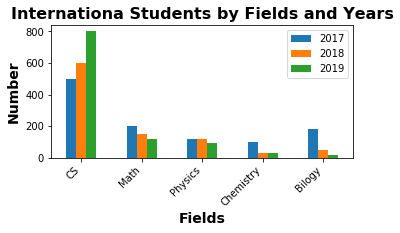

In [18]:
students_year.plot.bar(x = 'Fields', y = ['2017', '2018', '2019'])
#plt.bar(students_year.Fields, students_year[['2018', '2019']])
plt.title('Internationa Students by Fields and Years', fontsize = 16, fontweight = 'bold')
plt.xlabel('Fields', fontsize = 14, fontweight = 'bold')
plt.ylabel('Number', fontsize = 14, fontweight = 'bold')
# All the plots incude two parts: Figure and Axis
ax = plt.gca() # Get current axis, type: matplotlib.axes._subplots.AxesSubplot
ax.set_xticklabels(students_year.Fields, rotation = '45', ha = 'right', fontsize = 10)
f = plt.gcf() # Get current figure, type: matplotlib.figure.Figure
f.subplots_adjust(left = 0.2, bottom = 0.42)
plt.show()

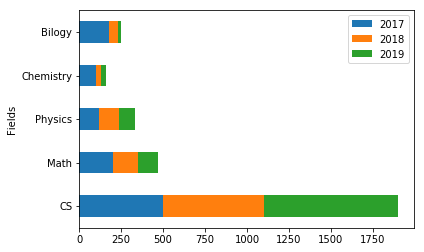

In [22]:
# Make it horizontal and stacked
students_year.plot.barh(x = 'Fields', y = ['2017', '2018', '2019'], stacked=True)